In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

In [32]:
median_df = pd.read_csv('/content/drive/MyDrive/ML Semester Project/TimeSeries_median_masked.csv')
max_df = pd.read_csv('/content/drive/MyDrive/ML Semester Project/TimeSeries_maximum.csv')
min_df = pd.read_csv('/content/drive/MyDrive/ML Semester Project/TimeSeries_minimum.csv')
average_df = pd.read_csv('/content/drive/MyDrive/ML Semester Project/TimeSeries_average_masked.csv')
population = pd.read_csv('/content/drive/MyDrive/MLproject/GDP_Population_Energy/population_updated.csv')

In [33]:
#dropping 2024 column since it is not part of our time series (2013-2023)
median_df = median_df.drop(['2024'], axis = 1)
max_df = max_df.drop(['2024'], axis = 1)
min_df = min_df.drop(['2024'], axis =1)
average_df = average_df.drop(['2024'], axis = 1)

In [34]:
population.rename(columns={'Country Name': 'Country'}, inplace=True)

In [35]:
average_long = average_df.melt(id_vars='Country', var_name='Year', value_name='Average_Masked')
max_long = max_df.melt(id_vars='Country', var_name='Year', value_name='Maximum')
min_long = min_df.melt(id_vars='Country', var_name='Year', value_name='Minimum')
median_long = median_df.melt(id_vars='Country', var_name='Year', value_name='Median_Masked')
population_long = population.melt(id_vars='Country', var_name='Year', value_name='Population')

In [36]:
#merging datasets
df = average_long.merge(max_long, on=['Country', 'Year'])
df = df.merge(min_long, on=['Country', 'Year'])
df = df.merge(median_long, on=['Country', 'Year'])
df = df.merge(population_long, on=['Country', 'Year'])

In [37]:
df

,Country,Year,Average_Masked,Maximum,Minimum,Median_Masked,Population
0,Uganda,2013,20976.358337,3.793496e+05,-75169.248639,18567.234269,35337042.0
1,Eritrea,2013,2478.380874,6.344756e+04,-51054.215196,2387.048038,3074360.0
2,Ethiopia,2013,47192.432397,1.851353e+06,-535710.656926,43817.541456,98438751.0
3,Comoros,2013,319.710920,2.038409e+03,-682.602949,302.185035,696192.0
4,Djibouti,2013,3232.446825,1.879628e+04,-8683.996654,2988.842974,984824.0
...,...,...,...,...,...,...,...
1788,Kiribati,2023,50.984408,8.373280e+02,251.804717,33.779881,132530.0
1789,Nauru,2023,373.323658,5.906410e+02,165.961677,349.601238,11875.0
1790,Tonga,2023,1035.870132,1.922797e+03,839.013738,1009.777802,104597.0
1791,Samoa,2023,1651.293407,7.392716e+03,2543.659931,1615.471331,216663.0


In [38]:
df['Year'] = df['Year'].astype(int)

# Sort for time series
df.sort_values(by=['Country', 'Year'], inplace=True)
df

,Country,Year,Average_Masked,Maximum,Minimum,Median_Masked,Population
91,Afghanistan,2013,92792.313774,1.091875e+06,190723.040993,88539.246767,31622704.0
254,Afghanistan,2014,82986.993879,1.090830e+06,23251.571958,80624.773952,32792523.0
417,Afghanistan,2015,73424.706667,1.054926e+06,45458.317460,70962.230817,33831764.0
580,Afghanistan,2016,71253.367845,8.178813e+05,-1799.889819,68843.099611,34700612.0
743,Afghanistan,2017,81674.809451,1.560382e+06,660310.840753,78654.057851,35688935.0
...,...,...,...,...,...,...,...
992,Zimbabwe,2019,49409.112783,7.378561e+05,86689.230187,46998.620320,15271368.0
1155,Zimbabwe,2020,49187.118091,8.230068e+05,169458.072419,47014.545921,15526888.0
1318,Zimbabwe,2021,58046.526323,9.885022e+05,258232.578915,55878.774081,15797210.0
1481,Zimbabwe,2022,64631.855230,1.157561e+06,93032.815369,60541.246624,16069056.0


In [42]:
pip install keras tcn

ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn


In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional, Input, Conv1D, LayerNormalization, ReLU, Add
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# Sequence Preparation
sequence_length = 10  # From 2013 to 2023
X, y, country_ids = [], [], []
scalers = {}

for country in df['Country'].unique():
    country_df = df[df['Country'] == country].copy()

    if len(country_df) <= sequence_length:
        continue

    features = country_df[['Average_Masked', 'Maximum', 'Minimum', 'Median_Masked']].values
    target = country_df['Population'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.hstack((target, features)))
    scalers[country] = scaler

    for i in range(sequence_length, len(scaled)):
        year = country_df.iloc[i]['Year']
        if year == 2023:
            X.append(scaled[i-sequence_length:i, 1:])  # NTL features only
            y.append(scaled[i, 0])  # Population
            country_ids.append(country)


In [49]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

X = np.array(X) # (num of samples(163), n of years(10), features(4))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
country_ids_test = country_ids[len(X_train):]

def evaluate_model(y_test_scaled, y_pred_scaled):
    y_true_inv, y_pred_inv = [], []
    # inverse scaling on y

    for i in range(len(y_test_scaled)):
        country = country_ids_test[i]
        scaler = scalers[country]

        dummy = np.zeros((1, 5))
        dummy[0, 0] = y_test_scaled[i]
        y_true_inv.append(scaler.inverse_transform(dummy)[0, 0])

        dummy[0, 0] = y_pred_scaled[i]
        y_pred_inv.append(scaler.inverse_transform(dummy)[0, 0])

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)
    return mae, r2

# model definitions
def build_lstm():
    model = Sequential([
        LSTM(64, input_shape=(X.shape[1], X.shape[2]),return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_bilstm():
    model = Sequential([
        Bidirectional(LSTM(64), input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    return model

def build_gru():
    model = Sequential([
        GRU(64, input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    return model

def build_tcn():
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, dilation_rate=1, padding='causal', activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Conv1D(filters=64, kernel_size=2, dilation_rate=2, padding='causal', activation='relu'),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=2, dilation_rate=4, padding='causal', activation='relu'),
        Dense(1)
    ])
    return model

# === 4. Train + Evaluate All Models ===

models = {
    "LSTM": build_lstm(),
    "Bi-LSTM": build_bilstm(),
    "GRU": build_gru(),
    "TCN": build_tcn()
}
results = []

for name, model in models.items():

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  model.summary()

  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

  y_pred_scaled = model.predict(X_test).flatten()
  mae, r2 = evaluate_model(y_test, y_pred_scaled)
  results.append({"Model": name, "MAE": mae, "R2": r2})
  print(f"{name} → MAE: {mae:.2f}, R2: {r2:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.6155 - val_loss: 0.1286
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2200 - val_loss: 0.1430
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1879 - val_loss: 0.1186
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1330 - val_loss: 0.1122
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1298 - val_loss: 0.1140
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1590 - val_loss: 0.1046
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1589 - val_loss: 0.1032
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1375 - val_loss: 0.1000
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1466 - val_loss: 0.0958
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1237 - val_loss: 0.0999
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1737 - val_loss: 0.0913
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,457 (138.50 KB)

 Trainable params: 35,457 (138.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.4321 - val_loss: 0.1120
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1815 - val_loss: 0.1172
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1405 - val_loss: 0.1032
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1404 - val_loss: 0.0998
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1136 - val_loss: 0.1158
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1313 - val_loss: 0.0918
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1183 - val_loss: 0.1011
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1227 - val_loss: 0.0884
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1409 - val_loss: 0.0868
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0981 - val_loss: 0.1098
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1320 - val_loss: 0.0860
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 64)             │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,505 (52.75 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.3101 - val_loss: 0.1234
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1614 - val_loss: 0.1275
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1488 - val_loss: 0.1041
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1080 - val_loss: 0.1072
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1828 - val_loss: 0.0991
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1317 - val_loss: 0.0995
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1531 - val_loss: 0.0911
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1403 - val_loss: 0.0929
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1410 - val_loss: 0.0867
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1237 - val_loss: 0.0886
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1174 - val_loss: 0.0839
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 10, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 10, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 10, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.6275 - val_loss: 0.2457
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2835 - val_loss: 0.1424
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1682 - val_loss: 0.1120
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1327 - val_loss: 0.0914
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1243 - val_loss: 0.0937
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1365 - val_loss: 0.0896
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1160 - val_loss: 0.0917
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1108 - val_loss: 0.0888
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1096 - val_loss: 0.0890
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1568 - val_loss: 0.0850
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1676 - val_loss: 0.0909
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step -

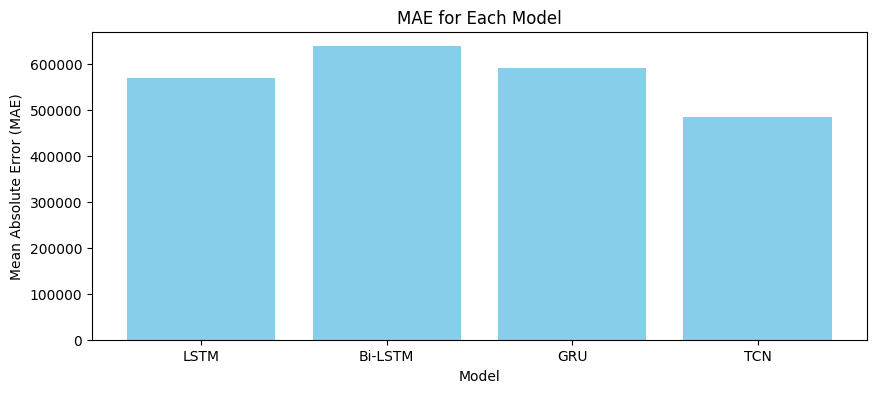

In [53]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(results)


# Plot MAE
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["MAE"], color="skyblue")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE for Each Model")
plt.show()



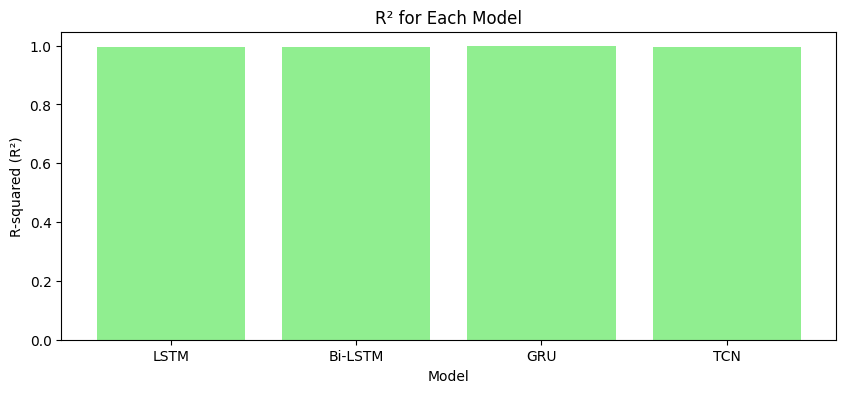

In [54]:
# Plot R2
plt.figure(figsize=(10, 4))
plt.bar(results_df["Model"], results_df["R2"], color="lightgreen")
plt.xlabel("Model")
plt.ylabel("R-squared (R²)")
plt.title("R² for Each Model")
plt.show()